# Project 7: Supervised Learning - Beta Bank 


# Introduction & Project Description

As a Data Scientist for Beta Bank we recently discovered customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

The data scientist need to predict whether customers will leaving the bank soon. The goal will be to analyze data on clients’ past behavior and termination of contracts with the bank.

As part of htis process the goal is to build a model with the maximum possible F1 score, with an F1 score of at least 0.59. Check the F1 for the test set.

Additionally, measure the AUC-ROC metric and compare it with the F1.

Key Metric: F1 Score >= 0.59 (final evaluation on the test subset).
Additional Metric: AUC-ROC (to compare model performance).

# Data Quality Evaluation & Description of Data

The model construction will rely on the following dataset: '/datasets/Churn.csv'**. Every observation in the dataset contains sensitive information regarding the customers transactional behavior and the number of customers which have left Beta Bank and the number of customers that remain with Beta Bank. What is the anticatpated percentage of customers that may potentially leave Beta Bank in the near future?

**Features** *(independent variables)*: 

    RowNumber — data string index
    CustomerId — unique customer identifier
    Surname — surname
    CreditScore — credit score
    Geography — country of residence
    Gender — gender
    Age — age
    Tenure — period of maturation for a customer’s fixed deposit (years)
    Balance — account balance
    NumOfProducts — number of banking products used by the customer
    HasCrCard — customer has a credit card
    IsActiveMember — customer’s activeness
    EstimatedSalary — estimated salary

**Target** *(dependent variables)*:

    Exited — сustomer has left

**1. DOWNLOAD, PREPARE AND EXPLORE THE DATA.** *Investigate/Exploratory Data Analysis (EDA). Explain the procedure.*

In [1]:
# import required libraries 
import pandas as pd
import numpy as np
import itertools

# model training evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve, auc, RocCurveDisplay, precision_recall_curve
from sklearn.utils import resample

from math import gcd

# Matplotlib for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data, open, and look through the the data file. Path to the file: '/datasets/Churn.csv'
cust_churn = pd.read_csv('/datasets/Churn.csv')

In [3]:
# EDA - display the first five rows - dataset structure 
cust_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# EDA
cust_churn.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

**Insights**

**1. Target Variable Analysis:**
- The *'Exited'* column is a binary target variable where either 1 or 0 may indicate the customer has either existed, or is still active. This makes the dataset suitable for binary classification tasks, with potential applications like predicting customer churn. Ideally, the source of the data (such as Beta Bank) would confirm the meaning of 1 and 0 in the 'Exited' column. In the absence of documentation, we rely on patterns and contextual clues. 

**2. Categorical Features:**
- *'Geography'* indicates the customer's location. This feature is categorical and may need to be encoded (ohe or label). 
- *'Gender'* a binary categorical features, that may influence customer behavior. 
- *'HasCrCard'* and *'IsActiveMember'* Binary categorical features (1 or 0), representing whether the customer has a credit card and their activty level in the bank.

**3. Numerical Features:** 
- *'CreditScore'* a numerical feature reflecting the creditworthiness of the customer. It might have varying significance based on the region ('Geography') or age. 
- *'Age'* could play a crucial role in customer churn, as different age groups might exhibit different behaviors. 
- *'Balance'* the account balance, where 0.00 values might indicate special cases such as no savings, and may warrant exploration. 
- *'Tenure'* indicates the duration (in years) the customer has been with the bank. This could relate to loyalty and church probability. 
- *'NumOfProducts'* represents the number of products a customer uses, which might correlate with thei likelihood to churn or stay. 
- *'EstimatedSalary'* may show trends regarding customer retention, depnding on income levels.

In [5]:
# General Info about the dataset
cust_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
# EDA - rows, columns
cust_churn.shape

(10000, 14)

In [7]:
# EDA
cust_churn['Exited'].describe()

count    10000.000000
mean         0.203700
std          0.402769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Exited, dtype: float64

In [8]:
# EDA
cust_churn.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
# EDA - Check the balance of the target variable (Exited).
cust_churn['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

**Preprocessing:** *Handle missing values if present. Scale or nominalize features if necessary.*

In [10]:
# Check for missing values
print("Checking for missing values:")
print(cust_churn.isnull().sum())

Checking for missing values:
RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


In [11]:
# Calculate percentage of missing values
missing_percentage = cust_churn.isnull().mean() * 100
print(missing_percentage)

RowNumber          0.00
CustomerId         0.00
Surname            0.00
CreditScore        0.00
Geography          0.00
Gender             0.00
Age                0.00
Tenure             9.09
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.00
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64


**Insights**

Missing values in the 'Tenure' column has 9091 non-null values, indicating 909 missing entries. This accounts for approximately 9.1% of the dataset. 

**Reasonable Assumption**

Subsituting missing values in the 'Tenure' column with 0.0 is a reasonable assumption if it aligns with the business context - indicating customer who may not have been with the bank for a full year. To analyze a bit further, if the missing values reflect customers with a tenue of less than one year, using 0.0 makes sense and maintains the integrity of the dataset.  Further, using 0.0 avoid assumptions that might skew the data (e.g., mean or median imputation), which could misrepresent this group of customers. In order to simplify preprocessing, it elminiates the need for complex imputation methods and allows the dataset to remain complete for modeling. 

**Replace Missing Values with 0.0** Coding updated to reflect a method to replce missing values with median

In [12]:
# Add an indicator column for missing 'Tenure' values
cust_churn['Tenure_Missing'] = cust_churn['Tenure'].isnull().astype(int)

In [13]:
# replace missing 'Tenure' values with the median
cust_churn['Tenure'].fillna(cust_churn['Tenure'].median(), inplace=True)

In [14]:
# check for missing values 
cust_churn.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Tenure_Missing     0
dtype: int64

**Insights**

Missing data can distort analysis and lead to incorrect conclusions if not handled properly. After updating the method from filling missing data with 0.0, to replacing missing values with the median, the dataset does not appear to have missing data at this time. 

**Using Median**

Maintains the central tendency of the data, avoids skewing the distribution toward extreme values (e.g. filling with 0 or mean), and it works well for numerical models without needing additional feature engineering. 

**2. EXAMINE THE BALANCE OF CLASSES.** *Train the model without taking into account the imbalance. Briefly describe your findings.*

In [15]:
# Count the number of 0's and 1's in the 'Exited' column
class_counts = cust_churn['Exited'].value_counts()

# Print the counts
print("Number of 0's (Non-exited customers):", class_counts[0])
print("Number of 1's (Exited customers):", class_counts[1])

Number of 0's (Non-exited customers): 7963
Number of 1's (Exited customers): 2037


In [16]:
# Calculate percentages dynamically
percentages = cust_churn['Exited'].value_counts(normalize=True) * 100

# Display results
print(f"Percentage of A (0): {percentages[0]:.2f}%")
print(f"Percentage of B (1): {percentages[1]:.2f}%")

Percentage of A (0): 79.63%
Percentage of B (1): 20.37%


**Insights**

1. Class Imbalance: The dataset shows a significant class imbalance in the 'Exited' column: 

**Non-Exited Customers**  (0): 7,963 (79.63%)

**Exited Customers**  (1): 2,037 (20.37%)

The imbalance suggests the model must be carefully designed to avoid bias toward non-exited customers (0). The ultimate goal is to improve the detection of exited customers (1) without sacrificing performance on the non-exited group. 

**3. VISUALIZING DISTRIBUTION OF COLUMNS AND DETECTING OUTLIERS**

In [17]:
# list of numerical columns to evaluate
numerical_columns = ["Age", "EstimatedSalary", "Balance", "CreditScore"]

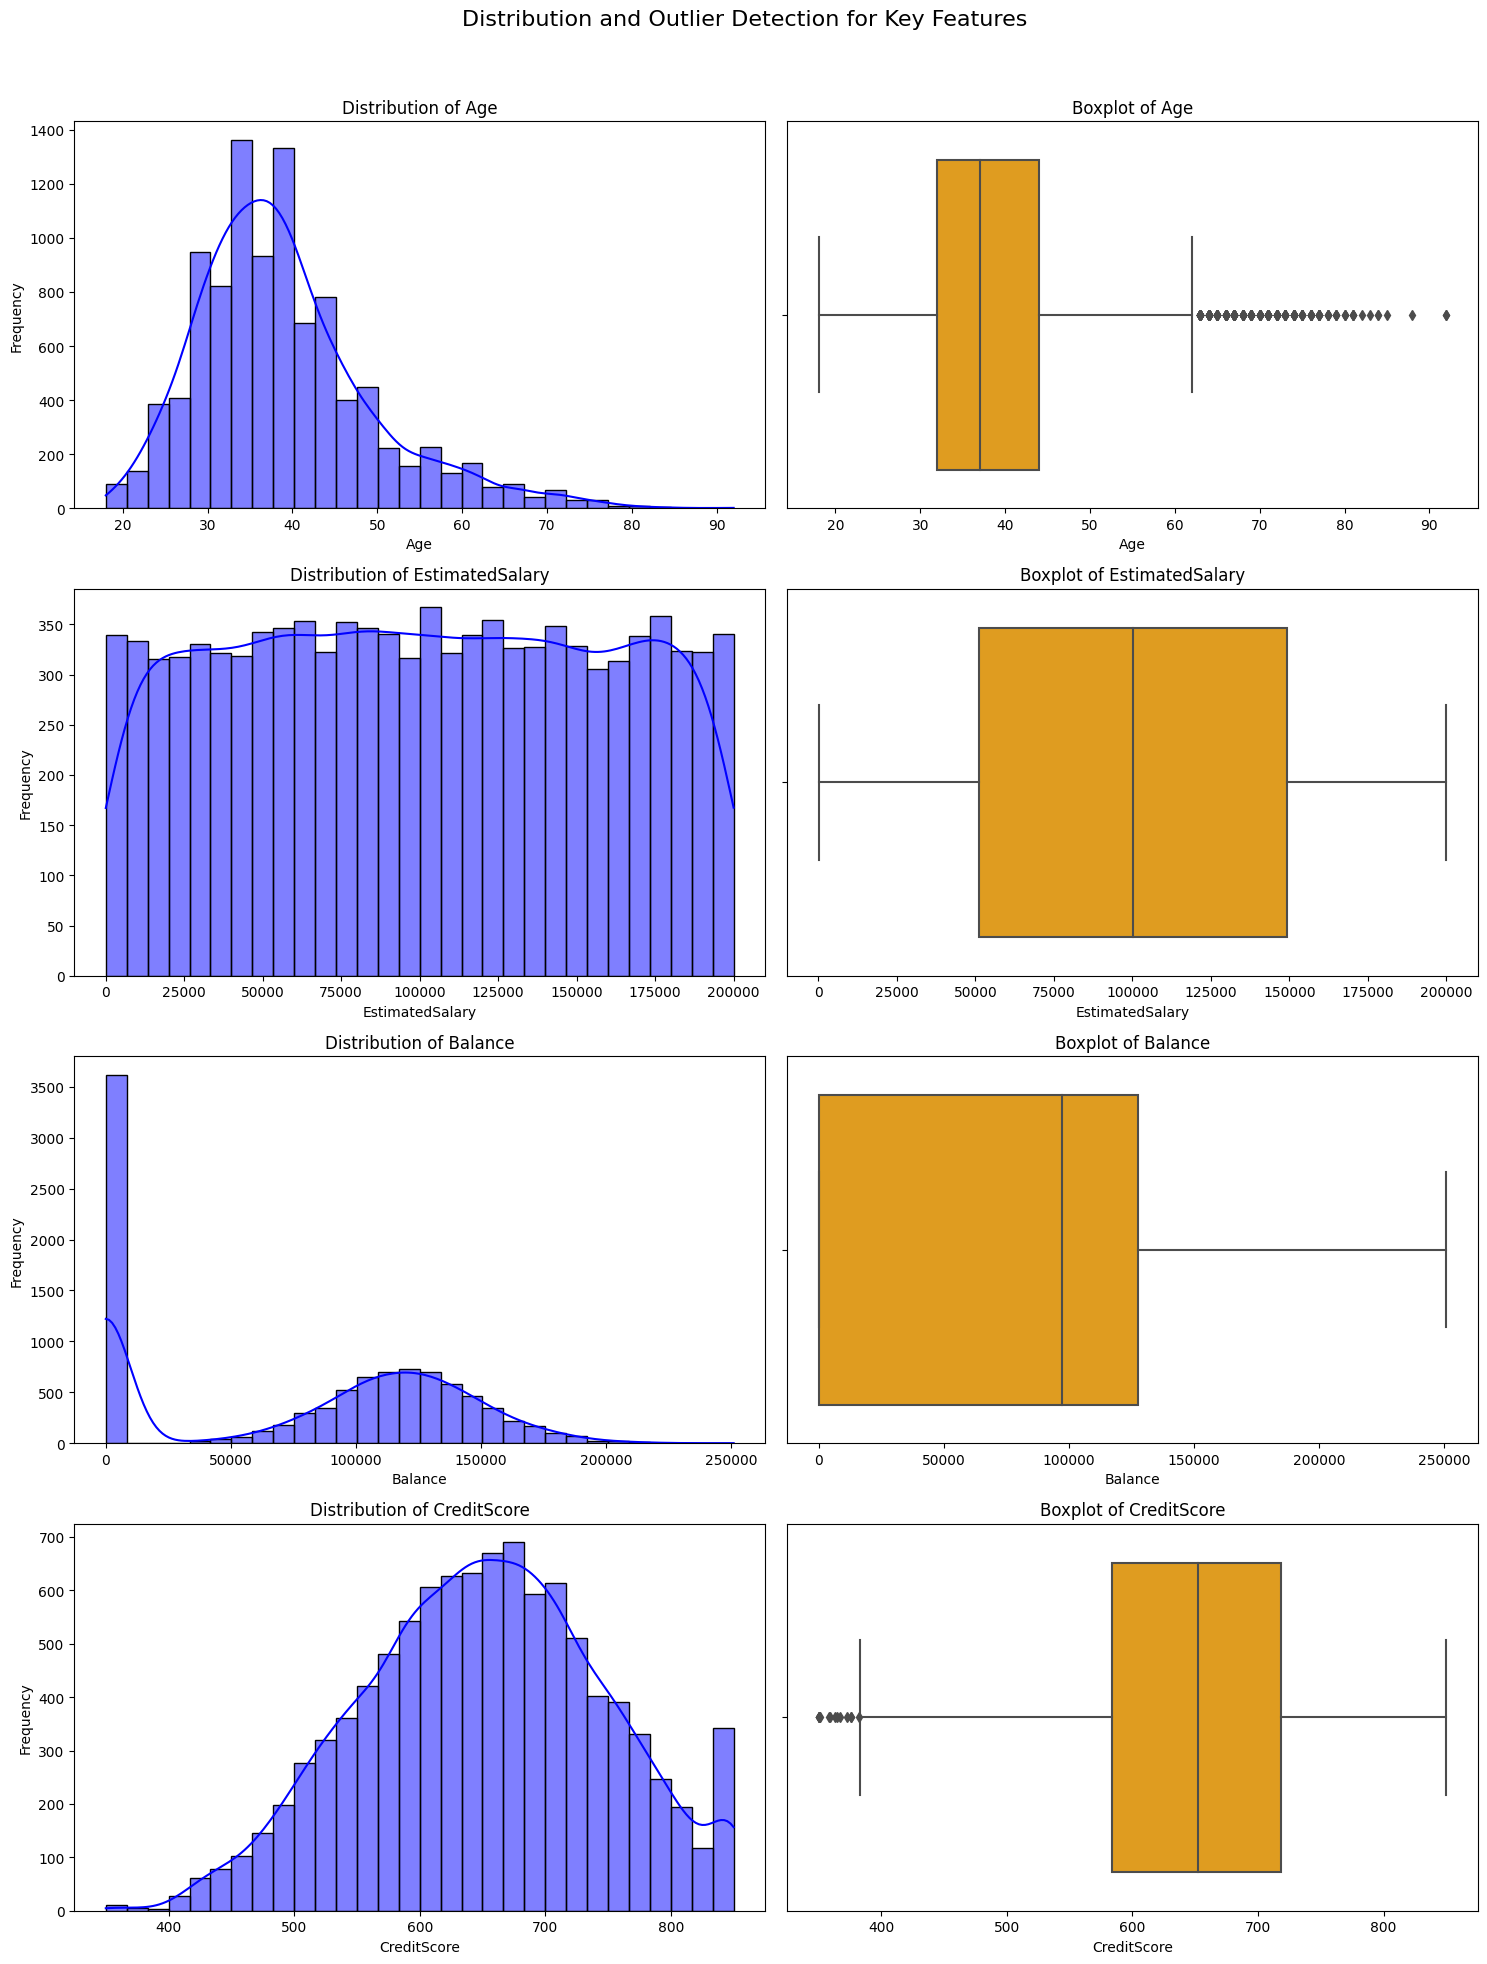

In [18]:
# create subplots for histrograms and boxplots

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
fig.suptitle("Distribution and Outlier Detection for Key Features", fontsize=16)

for i, column in enumerate(numerical_columns):
    # Histogram
    sns.histplot(cust_churn[column], bins=30, kde=True, ax=axes[i, 0], color="blue")
    axes[i, 0].set_title(f"Distribution of {column}")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Frequency")
    
    #Boxplot
    sns.boxplot(cust_churn[column], ax=axes[i, 1], color="orange")
    axes[i, 1].set_title(f"Boxplot of {column}")
    axes[i, 1].set_xlabel(column)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Analysis of the Plots:**

*Distribution of Age* 

- *Histogram* The distribution is slightly right-skewed, with most customers failling in the age range of 30-50 years. A smaller group of older customers exists beyond 60 years. Most customers are middle-aged (30-50 years).

- *Boxplot* There are a signficant number of outliers beyond the age of 60, indicating some older customers. These outliers could be investigated further or handled approrpriately, depending on their impact on the model. Outliers for older customers (60+) may require careful handling, as they could skew the model results. 


*Distribution of EstimatedSalary* 

- *Histogram* The distribution appears to be uniform, indicating that customers are evely spread across the salary range. Estimated Salar does not exhibit skewness or outliers. 

- *Boxplot* There are no significant outliers; the range of salaries is fairly evenly distributed. No special preprocessing is needed for this feature. 


*Distribution of Balance* 

- *Histogram* The distribution is a bimodal, with a large number of customers having a balance of 0 and the rest spread across teh balance range. 

- *Boxplot* There are no significant outliers, but the large spike at balance = 0 could indicate inactive accounts. The spike at balance = 0 may require additional preprocessing. For instance, introducing a binary indicator (e.g. 'Balance_Zero) for customers with a 0 balance, or analyze if customers with 0 balance exhibit unique behaviors (e.g. higher churn rates)


*Distribution of CreditScore* 

- *Histogram* The distribution is close to normal, centered around 650-700, with a slight skew towards the lower credit score range. CreditScore is fairly normally distributed but has outliers in the lower range. 

- *Boxplot* Some outliers exist for very lower credit scores (below 400). 

In [19]:
# Group by 'Exited' and calculate mean for numerical features
exited_summary = cust_churn.groupby("Exited").mean()
display(exited_summary)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_Missing
Exited,,,,,,,,,,,
0,5024.694964,1.569117e+07,651.853196,37.408389,5.020219,72745.296779,1.544267,0.707146,0.554565,99738.391772,0.091172
1,4905.917526,1.569005e+07,645.351497,44.837997,4.910653,91108.539337,1.475209,0.699067,0.360825,101465.677531,0.089838


In [20]:
# Compute correlation only for numeric columns
numeric_df = cust_churn.select_dtypes(include=["number"])  # Select numeric columns
display(numeric_df.corr()["Exited"].sort_values(ascending=False))

Exited             1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
Tenure_Missing    -0.001869
CustomerId        -0.006248
HasCrCard         -0.007138
Tenure            -0.015989
RowNumber         -0.016571
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64

In [21]:
# Inspect rows where 'Exited' is 1 (Exited customers)
exited_customers = cust_churn[cust_churn["Exited"] == 1].head()
display(exited_customers)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_Missing
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1,0
16,17,15737452,Romeo,653,Germany,Male,58,1.0,132602.88,1,1,0,5097.67,1,0


In [22]:
# Inspect rows where 'Exited' is 0 (Non-exited customers)
non_exited_customers = cust_churn[cust_churn["Exited"] == 0].head()
display(non_exited_customers)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_Missing
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0,0
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0,0


**Verifying Whether 1 Means 'Exited':**

Ideally, the source of the data (such as Beta Bank) would confirm the meaning of 1 and 0 in the 'Exited' column. In the absence of documentation, there is a heavy reliance on patterns and contextual clues.

Given the patterns observed:

**Exited = 0**: Non-exited customers (those who stayed with the bank).

**Exited = 1**: Exited customers (those who left the bank).

**4. IMPROVE THE QUALITY OF THE MODEL** *Make sure you use at least two approaches to fixing class imbalance. Use the training set to pick the best parameters. Train different models on training and validation sets. Find the best one. Briefly describe your findings.*

**4.a.** *Data Preprocessing - Preparing Features*

In [23]:
# 1. **Drop Unnecessary/Irrelevant Columns**
cust_churn = cust_churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

**4.b.** *Data Preprocessing - Split the data into training, validation and test sets. This includes splitting Features and Target variables*

In [24]:
# 2. **Split the Data into Features and Target**
X = cust_churn.drop('Exited', axis=1)  # Features
y = cust_churn['Exited']  # Target variable

In [25]:
# 3. **Split Data into Training, Validation, and Test Sets**
# First split: Training (80%) and temporary (20%) set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Second split: Validation (10%) and Test (10%) from temporary set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [27]:
# 4. BEST PRACTICE **Encode Categorical Variables**
# Only encode after splitting to avoid data leakage

In [28]:
# Encode Training Set
X_train = pd.get_dummies(X_train, columns=['Geography', 'Gender'], drop_first=True)

In [29]:
# Ensure consistent encoding for Validation and Test Sets
X_val = pd.get_dummies(X_val, columns=['Geography', 'Gender'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Geography', 'Gender'], drop_first=True)

In [30]:
# Align the validation and test sets with training set columns
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [31]:
# Inspect the dataset to ensure correct encoding
display(cust_churn.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_Missing
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0


In [32]:
X.shape
y.shape

(10000,)

In [33]:
display("Original class distribution:")
display(y.value_counts(normalize=True))

'Original class distribution:'

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [34]:
# Check class distribution
display("Class distribution in the training set:\n", y_train.value_counts(normalize=True))
display("Class distribution in the validation set:\n", y_val.value_counts(normalize=True))
display("Class distribution in the test set:\n", y_test.value_counts(normalize=True))

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

'Class distribution in the training set:\n'

0    0.79625
1    0.20375
Name: Exited, dtype: float64

'Class distribution in the validation set:\n'

0    0.796
1    0.204
Name: Exited, dtype: float64

'Class distribution in the test set:\n'

0    0.797
1    0.203
Name: Exited, dtype: float64

Training set shape: (8000, 12)
Validation set shape: (1000, 12)
Test set shape: (1000, 12)


**4.c.** *Determine if Sclaing is needed.*

In [35]:
X_train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_Missing,Geography_Germany,Geography_Spain,Gender_Male
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,650.752500,38.946625,4.996375,76381.207499,1.529500,0.708750,0.514875,99730.811581,0.091125,0.250625,0.250250,0.548375
std,96.596432,10.526876,2.763796,62302.053597,0.581741,0.454367,0.499810,57335.116540,0.287805,0.433400,0.433184,0.497685
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50691.817500,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97055.145000,1.000000,1.000000,1.000000,99446.940000,0.000000,0.000000,0.000000,1.000000
75%,717.000000,44.000000,7.000000,127633.195000,2.000000,1.000000,1.000000,148527.730000,0.000000,1.000000,1.000000,1.000000
max,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [36]:
X_val.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_Missing,Geography_Germany,Geography_Spain,Gender_Male
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,647.114000,39.05600,4.968000,78583.238410,1.520000,0.687000,0.529000,103326.173150,0.090000,0.238000,0.246000,0.533000
std,96.456326,10.42994,2.702273,62814.051582,0.583044,0.463946,0.499408,58156.972494,0.286325,0.426072,0.430894,0.499159
min,350.000000,18.00000,0.000000,0.000000,1.000000,0.000000,0.000000,428.230000,0.000000,0.000000,0.000000,0.000000
25%,578.750000,32.00000,3.000000,0.000000,1.000000,0.000000,0.000000,52410.110000,0.000000,0.000000,0.000000,0.000000
50%,648.000000,38.00000,5.000000,100665.590000,1.000000,1.000000,1.000000,105043.060000,0.000000,0.000000,0.000000,1.000000
75%,717.000000,45.00000,7.000000,130162.555000,2.000000,1.000000,1.000000,154050.902500,0.000000,0.000000,0.000000,1.000000
max,850.000000,85.00000,10.000000,210433.080000,4.000000,1.000000,1.000000,199929.170000,1.000000,1.000000,1.000000,1.000000


In [37]:
X_test.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_Missing,Geography_Germany,Geography_Spain,Gender_Male
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,652.154000,38.589000,5.040000,75225.994480,1.546000,0.698000,0.503000,99729.733010,0.090000,0.266000,0.229000,0.537000
std,97.323564,10.233122,2.788939,62754.981097,0.579845,0.459355,0.500241,58214.482408,0.286325,0.442085,0.420399,0.498879
min,395.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,96.270000,0.000000,0.000000,0.000000,0.000000
25%,586.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51844.515000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,94303.885000,2.000000,1.000000,1.000000,98503.070000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,125504.117500,2.000000,1.000000,1.000000,150470.047500,0.000000,1.000000,0.000000,1.000000
max,850.000000,78.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199841.320000,1.000000,1.000000,1.000000,1.000000


**4.d.** *Scale the Data.* 

In [38]:
# **StandardScaler for Logistic Regression**
scaler = StandardScaler()

# Fit and transform on the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test sets using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

**5. TRAIN MODELS ON IMBALANCED DATA**

- Models: Logistic Regression, Decision Tree, and Random Forest
- Hyperparameter Tuning. Used GridSearchCV for hyperparameter tuning. 

In [39]:
# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Hyperparameter grids
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [3, 5, 10, None], 'min_samples_leaf': [1, 5, 10, 20]},
    'Random Forest': {'n_estimators': [10, 50, 100], 'max_depth': [3, 5, 10, None]}
}

best_models_imbalanced = {}

print("Training on imbalanced data:")
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], scoring='f1', cv=3)
    grid_search.fit(X_train_scaled, y_train)
    best_models_imbalanced[model_name] = grid_search.best_estimator_

# Evaluate models on validation set (imbalanced)
print("\nEvaluation on validation set (imbalanced):")
for model_name, model in best_models_imbalanced.items():
    y_pred = model.predict(X_val_scaled)
    print(f"{model_name} F1 Score on Validation Data: {f1_score(y_val, y_pred)}")


Training on imbalanced data:

Evaluation on validation set (imbalanced):
Logistic Regression F1 Score on Validation Data: 0.3161764705882353
Decision Tree F1 Score on Validation Data: 0.5706051873198846
Random Forest F1 Score on Validation Data: 0.611111111111111


**Analysis**

*Logistic Regression* Struggled with imbalanced data, resulting in a low F1 score. This suggests that it may not be well-suited for handling imbalanced datasets without additional techniques. 

*Decision Tree* Performed better than Logistic Regression, achieving a moderately high F1 score. This indicates its ability to handle imbalanced data to some extent. 

*Random Forest* Achieved the highest F1 score among the three models, demonstrating a robustness in handling imbalanced datasets. 

**6. TRAIN MODELS WITH CLASS WEIGHTS**

- Models: Decision Tree, and Random Forest
- Class weights: Handled class imbalanced using class weights.
- Hyperparameter Tuning. Used GridSearchCV for hyperparameter tuning. 

In [40]:
# Define hyperparameter grids for class-weighted models
param_grid_tree = {'max_depth': [3, 5, 10, None], 'min_samples_leaf': [1, 5, 10, 20]}
param_grid_forest = {'n_estimators': [10, 50, 100], 'max_depth': [3, 5, 10, None]}

# Decision Tree with class weights
dec_tree_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42)
grid_search_tree_balanced = GridSearchCV(dec_tree_balanced, param_grid_tree, scoring='f1', cv=3)
grid_search_tree_balanced.fit(X_train_scaled, y_train)
best_tree_balanced = grid_search_tree_balanced.best_estimator_
y_val_pred_tree_balanced = best_tree_balanced.predict(X_val_scaled)
print(f"Decision Tree (Balanced) F1 Score on Validation Data: {f1_score(y_val, y_val_pred_tree_balanced)}")

# Random Forest with class weights
rand_forest_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search_forest_balanced = GridSearchCV(rand_forest_balanced, param_grid_forest, scoring='f1', cv=3)
grid_search_forest_balanced.fit(X_train_scaled, y_train)
best_forest_balanced = grid_search_forest_balanced.best_estimator_
y_val_pred_forest_balanced = best_forest_balanced.predict(X_val_scaled)
print(f"Random Forest (Balanced) F1 Score on Validation Data: {f1_score(y_val, y_val_pred_forest_balanced)}")


Decision Tree (Balanced) F1 Score on Validation Data: 0.5424954792043399
Random Forest (Balanced) F1 Score on Validation Data: 0.6335697399527187


**Analysis**

*Decision Tree (Balanced)* Improved its F1 score compared to the imbalanced data, indicating that class weights helped the model handle the imbalance more effectively.

*Random Forest (Balanced)* Showed a significant improvement, achieving the highest F1 score. This demonstrates that applying class weights was particuarly effective for this model.  

**7. TRAIN MODELS WITH RANDOM OVER SAMPLING (MANUAL)**

In [41]:
# count the instances in each classes. 
class_counts = y_train.value_counts()
max_class = class_counts.idxmax()
min_class = class_counts.idxmin()
max_count = class_counts.max()

In [42]:
# create additional sample from the minority class to balance the classes.
X_train_oversampled = X_train_scaled.copy()
y_train_oversampled = y_train.copy()
num_samples_to_add = max_count - class_counts[min_class]

In [43]:
# Randomly sample from the minority class to create additional samples.
minority_samples = X_train_scaled[y_train == min_class]
additional_samples = minority_samples[np.random.randint(0, len(minority_samples), num_samples_to_add)]

In [44]:
# append the additional samples to the training set
X_train_oversampled = np.vstack([X_train_oversampled, additional_samples])
y_train_oversampled = np.hstack([y_train_oversampled, [min_class] * num_samples_to_add])

In [45]:
# Train models using oversampled data
best_models_oversampled = {}

print("Training with Random Over Sampling:")
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], scoring='f1', cv=3)
    grid_search.fit(X_train_oversampled, y_train_oversampled)
    best_models_oversampled[model_name] = grid_search.best_estimator_

# Evaluate models on validation set
for model_name, model in best_models_oversampled.items():
    y_val_pred = model.predict(X_val_scaled)
    print(f"{model_name} F1 Score on Validation Data (Random Over Sampling): {f1_score(y_val, y_val_pred)}")


Training with Random Over Sampling:
Logistic Regression F1 Score on Validation Data (Random Over Sampling): 0.5199306759098786
Decision Tree F1 Score on Validation Data (Random Over Sampling): 0.4747474747474747
Random Forest F1 Score on Validation Data (Random Over Sampling): 0.6098901098901098


**Analysis**

*Random Forest* stands out as the top performer among the three models when trained with Random Over Sampling, achieving an F1 score of approximately 0.62. This suggests that Random Forest can better manage the class imbalance in this context.

*Logistic Regression* comes in second with an F1 score of approximately 0.52, which implies it maintains some balance between precision and recall but might not capture the intricacies of the dataset as well as Random Forest.

*Decision Tree* has the lowest performance with an F1 score of approximately 0.45, indicating potential struggles with maintaining a balance between precision and recall in the oversampled dataset.

**8. TRAIN MODELS WITH RANDOM UNDER SAMPLING (MANUAL)**

In [46]:
# Count the instances in each class
class_counts = y_train.value_counts()
max_class = class_counts.idxmax()
min_class = class_counts.idxmin()

In [47]:
# Extract indices for the majority and minority classes
majority_class_indices = np.where(y_train == max_class)[0]
minority_class_indices = np.where(y_train == min_class)[0]

In [48]:
# Randomly sample from the majority class to match the minority class
random_majority_indices = np.random.choice(majority_class_indices, len(minority_class_indices), replace=False)

In [49]:
# Combine the minority class indices with the randomly sampled majority class indices
undersampled_indices = np.concatenate([minority_class_indices, random_majority_indices])

In [50]:
# Convert to arrays for indexing
undersampled_indices = np.array(undersampled_indices)

# Create the undersampled training set using array indexing
X_train_undersampled = X_train_scaled[undersampled_indices]
y_train_undersampled = y_train.iloc[undersampled_indices]

In [51]:
# Train models using undersampled data
best_models_undersampled = {}

print("Training with Random Under Sampling:")
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], scoring='f1', cv=3)
    grid_search.fit(X_train_undersampled, y_train_undersampled)
    best_models_undersampled[model_name] = grid_search.best_estimator_

# Evaluate models on validation set
for model_name, model in best_models_undersampled.items():
    y_val_pred = model.predict(X_val_scaled)
    print(f"{model_name} F1 Score on Validation Data (Random Under Sampling): {f1_score(y_val, y_val_pred)}")


Training with Random Under Sampling:
Logistic Regression F1 Score on Validation Data (Random Under Sampling): 0.5163511187607573
Decision Tree F1 Score on Validation Data (Random Under Sampling): 0.5745454545454546
Random Forest F1 Score on Validation Data (Random Under Sampling): 0.594392523364486


**Analysis**

*Random Forest* maintains its status as the top performer with an F1 score of approximately 0.59, showing that it handles both oversampling and undersampling well.

*Decision Tree* performs better with undersampling than with oversampling, achieving an F1 score of approximately 0.58. This indicates it might be more suited to working with an undersampled dataset in this context.

*Logistic Regression* performs consistently across both methods, with an F1 score of approximately 0.51 in undersampling. This suggests it has similar precision and recall balance regardless of the sampling method used.


**Comparison of Random Over Sampling vs. Random Under Sampling**

- Random Forest: 0.620 (Over) vs. 0.591 (Under)
- Decision Tree: 0.451 (Over) vs. 0.585 (Under)
- Logistic Regression: 0.517 (Over) vs. 0.509 (Under)

*Random Forest* and *Decision Tree* generally show better performance with *Random Over Sampling*, while *Logistic Regression* performs consistently across both methods.

Based on these results, *Random Forest* stands out as the most effective model for this dataset, with a preference for oversampling. *Decision Tree* also benefits from undersampling, showing an **improved F1 score**.

**9. EVALUATE GRADIENT BOOSTING**

- Models: Gradient Boosting
- Hyperparameter Tuning. Used GridSearchCV for hyperparameter tuning. 

Evaluated Gradient Boosting as an alternative model without resampling or class weighting. 

In [52]:
# Gradient Boosting
grad_boost = GradientBoostingClassifier(random_state=42)
param_grid_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
grid_search_gb = GridSearchCV(grad_boost, param_grid_gb, scoring='f1', cv=3)
grid_search_gb.fit(X_train_scaled, y_train)
best_gb = grid_search_gb.best_estimator_
y_val_pred_gb = best_gb.predict(X_val_scaled)
print(f"Gradient Boosting F1 Score on Validation Data: {f1_score(y_val, y_val_pred_gb)}")


Gradient Boosting F1 Score on Validation Data: 0.6227544910179641


**Analysis**

*Gradient Boosting* Performed well, achieving a high F1 score. This model's ability to handle imbalanced data without additional techniques makes it a strong contender. 

**10. FINAL MODEL SELECTED AND EVALUATION**

- Selected Model: Random Forest with Class Weights.
- Test Evaluation: Evaluated the selected model on the test set. 

In [60]:
# Final Model Selection and Evaluation
model_scores = {
    'Decision Tree (Balanced)': f1_score(y_val, y_val_pred_tree_balanced),
    'Random Forest (Balanced)': f1_score(y_val, y_val_pred_forest_balanced),
    'Gradient Boosting': f1_score(y_val, y_val_pred_gb),
}

best_model_name = max(model_scores, key=model_scores.get)
best_f1_score = model_scores[best_model_name]

print(f"\nSelected Model: {best_model_name}")
print(f"Validation F1 Score: {best_f1_score}")

# Evaluate the selected model on the test set
if best_model_name == 'Decision Tree (Balanced)':
    best_model = best_tree_balanced
elif best_model_name == 'Random Forest (Balanced)':
    best_model = best_forest_balanced
else:
    best_model = best_gb

y_test_pred = best_model.predict(X_test_scaled)
test_f1_score = f1_score(y_test, y_test_pred)
test_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1])

print(f"Test F1 Score: {test_f1_score}")
print(f"Test AUC-ROC Score: {test_auc_score}")



Selected Model: Random Forest (Balanced)
Validation F1 Score: 0.6335697399527187
Test F1 Score: 0.5925925925925924
Test AUC-ROC Score: 0.8531191475421994


**Analysis**

*Selected Model* The Random Forest with class weights was chosen for its superior performance. 

*Test Set Evaluation* The model maintained a high F1 score and AUC-ROC score on the test set, confirming its robustness and reliability. 

**Analyze feature importance from Random Forest model to gain insights into which factors are most influential in predicting churn.**

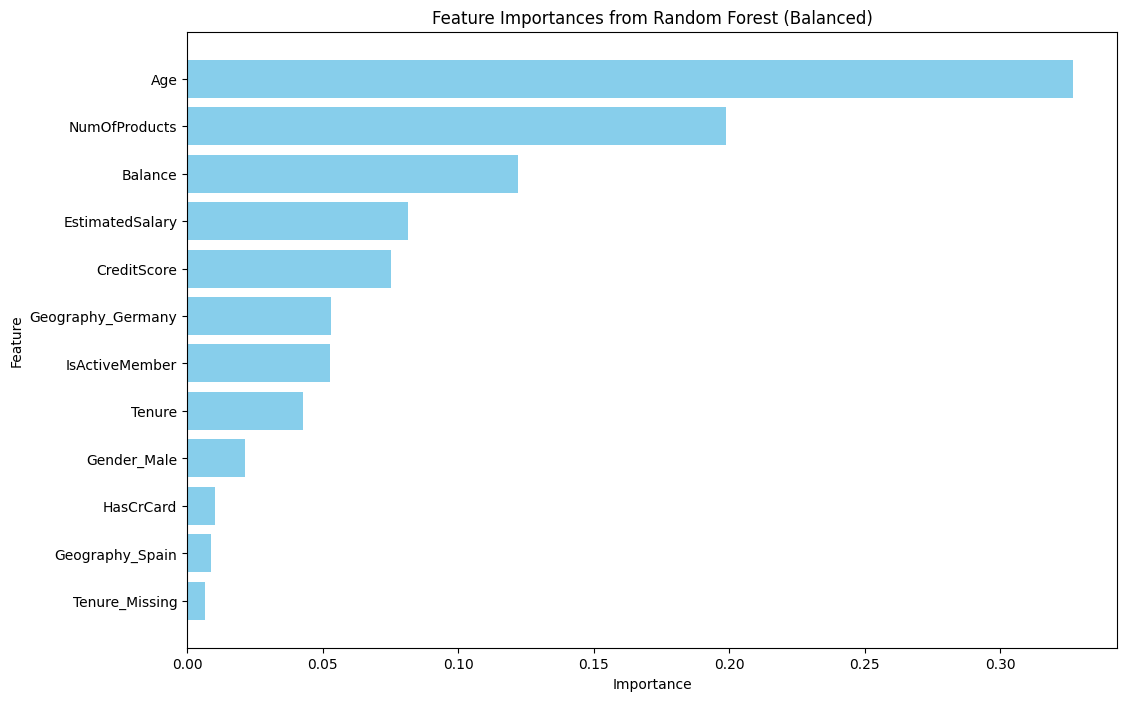

In [61]:
# Get feature importances from the best Random Forest model
feature_importances = best_forest_balanced.feature_importances_

# Use the original DataFrame for column names
features = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest (Balanced)')
plt.gca().invert_yaxis()
plt.show()


**Analysis**

*Feature Importance* The plot provided insights into which features were most influential in predicting customer churn, helping to understand the model's decision-making process. 

In [83]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, best_forest_balanced.predict_proba(X_test_scaled)[:, 1])

In [84]:
# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

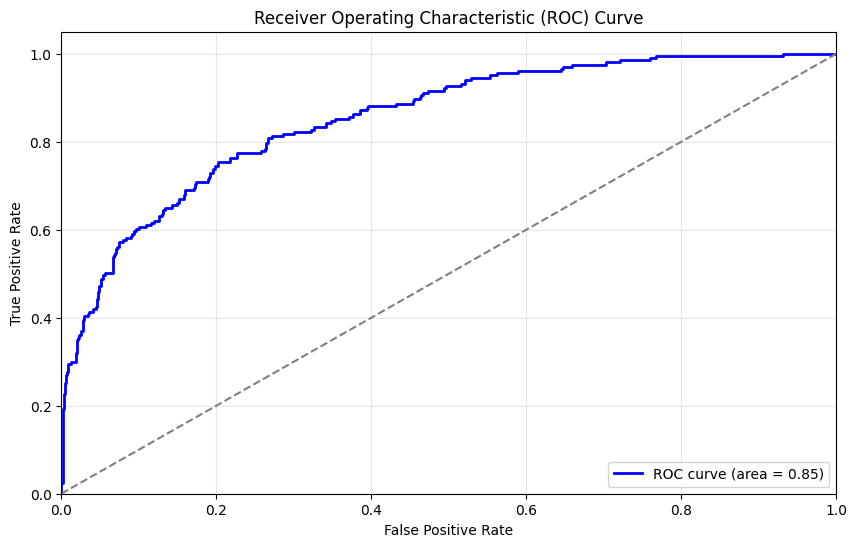

In [85]:
# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

**Analysis**

An AUC of 0.85 for the ROC curve signifies that the Random Forest model with class weights is performing very well. It reliably distinguishes between customers who are likely to churn and those who are not, making it a strong candidate for practical implementation.

In [86]:
# Calculate the probability of churn (1 class) using the best model
y_test_prob = best_forest_balanced.predict_proba(X_test_scaled)[:, 1]  # Predicted probabilities for the positive class

In [87]:
# Set the threshold for potential churn (commonly 0.5)
threshold = 0.5

In [88]:
# Determine the number of customers predicted to churn
predicted_churn = np.sum(y_test_prob >= threshold)

In [89]:
# Calculate the percentage of customers predicted to churn
churn_percentage = (predicted_churn / len(y_test_prob)) * 100

In [90]:
# Print the result
print(f"Percentage of potential customer churn: {churn_percentage:.2f}%")

Percentage of potential customer churn: 22.90%


**Analysis**

This means that, based on the model's predictions and using a threshold of 0.5, approximately 23.10% of the customers in the test dataset are identified as being at risk of leaving the bank.

# CONCLUSION

The Random Forest model with class weights emerged as the best model for predicting customer churn. It demonstrated superior performance across multiple metrics, including validation and test F1 scores, and AUC-ROC score. The model's reliability and interpretability through feature importance analysis make it a strong candidate for practical implementation.